In [7]:
import os
import time
import torch
import clip
import faiss
import psutil
import GPUtil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from torchvision import transforms
import hdbscan

CONFIGURATION


In [8]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_FOLDER = "C:/Users/megdy/Desktop/stat 4830/STAT-4830-vllm-project/shopping-images"  # Change this to your folder
EPS = 0.3  # Distance threshold for DBSCAN (adjustable)
MIN_SAMPLES = 2  # Minimum number of points to form a cluster
MAX_SAMPLES = 1000

FUNCTION TO TRACK RESOURCE USAGE

In [9]:
def print_system_usage():
    """Print CPU, memory, and GPU usage."""
    cpu_percent = psutil.cpu_percent()
    mem_info = psutil.virtual_memory()
    mem_percent = mem_info.percent
    gpu_percent = None
    gpu_mem_used = None
    
    if DEVICE == "cuda":
        gpus = GPUtil.getGPUs()
        if gpus:
            gpu_percent = gpus[0].load * 100  # GPU usage percentage
            gpu_mem_used = gpus[0].memoryUsed  # GPU memory usage in MB

    print(f"CPU Usage: {cpu_percent}% | Memory Usage: {mem_percent}%")
    if gpu_percent is not None:
        print(f"GPU Usage: {gpu_percent:.2f}% | GPU Memory Used: {gpu_mem_used}MB")



LOAD CLIP MODEL

In [10]:
print("Loading CLIP model...")
start_time = time.time()
model, preprocess = clip.load("ViT-B/32", device=DEVICE)
print(f"CLIP model loaded in {time.time() - start_time:.2f} seconds.")
print_system_usage()

Loading CLIP model...
CLIP model loaded in 7.09 seconds.
CPU Usage: 4.6% | Memory Usage: 93.6%


FUNCTION TO GET IMAGE EMBEDDINGS


In [11]:
def get_clip_embedding(image_path):
    """Extract CLIP embedding for an image"""
    image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        embedding = model.encode_image(image).cpu().numpy()
    return embedding.squeeze()  # Convert to 1D array


PROCESS ALL IMAGES IN THE FOLDER


In [12]:
print("Extracting embeddings...")
start_time = time.time()
image_paths = [os.path.join(IMAGE_FOLDER, f) for f in os.listdir(IMAGE_FOLDER) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Generate embeddings for all images
embeddings = np.array([get_clip_embedding(img) for img in image_paths])
print(f"Embeddings extracted in {time.time() - start_time:.2f} seconds.")
print_system_usage()

# Store embeddings in a DataFrame (optional)
df = pd.DataFrame(embeddings)
df["image_path"] = image_paths
df.to_csv("image_embeddings.csv", index=False)  # Save for future use

Extracting embeddings...
Embeddings extracted in 24.83 seconds.
CPU Usage: 10.3% | Memory Usage: 88.6%


CLUSTERING USING different methods; could change depending on dataset size

In [13]:
print(f"Clustering {len(image_paths)} images...")
start_time = time.time()

# Normalize embeddings before clustering
scaled_embeddings = StandardScaler().fit_transform(embeddings)

Clustering 76 images...


In [14]:

# Apply DBSCAN + cosine similarity
# Compute Cosine Similarity Matrix
# cosine_sim_matrix = cosine_similarity(embeddings)
# Convert similarity to distance (ensure values are non-negative)
# distance_matrix = 1 - cosine_sim_matrix
# distance_matrix = np.clip(distance_matrix, 0, 1)  # Fix negative values
# Apply DBSCAN with precomputed distances
# dbscan = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES, metric="precomputed")
# labels = dbscan.fit_predict(distance_matrix)

In [15]:
#Apply just DBSCAN
# dbscan = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES, metric='euclidean')
# labels = dbscan.fit_predict(scaled_embeddings)

In [16]:
#Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric="euclidean")
labels = clusterer.fit_predict(embeddings)

In [17]:
# Get number of clusters (excluding noise)
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"HDBSCAN found {num_clusters} clusters.")
print_system_usage()

HDBSCAN found 3 clusters.
CPU Usage: 11.2% | Memory Usage: 88.7%


In [18]:
# Group images by cluster
clusters = {}
for idx, label in enumerate(labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(image_paths[idx])



DISPLAY CLUSTERED IMAGES

In [19]:
def display_cluster_images(cluster_id, max_images=10):
    """Display images from a given cluster"""
    if cluster_id == -1:
        print("Displaying outliers (images that didn't fit into a cluster):")
    else:
        print(f"Displaying images for Cluster {cluster_id}:")
    
    images = clusters[cluster_id][:max_images]  # Limit number of images displayed
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    
    for ax, img_path in zip(axes, images):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(f"Cluster {cluster_id}")
        ax.axis("off")
    
    plt.show()

Displaying outliers (images that didn't fit into a cluster):


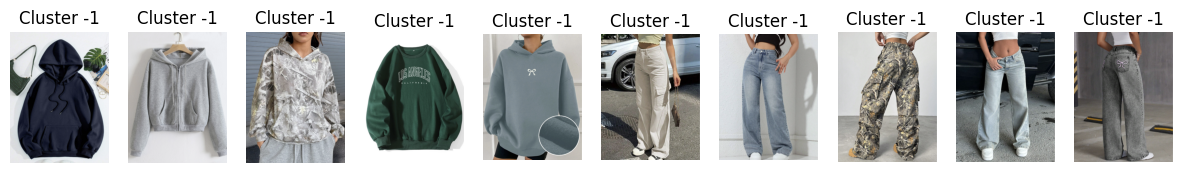

Displaying images for Cluster 1:


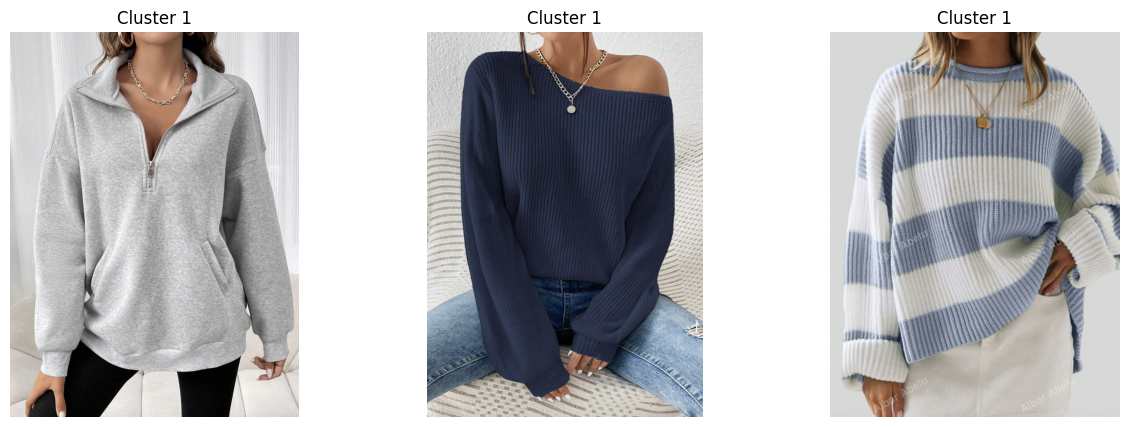

Displaying images for Cluster 2:


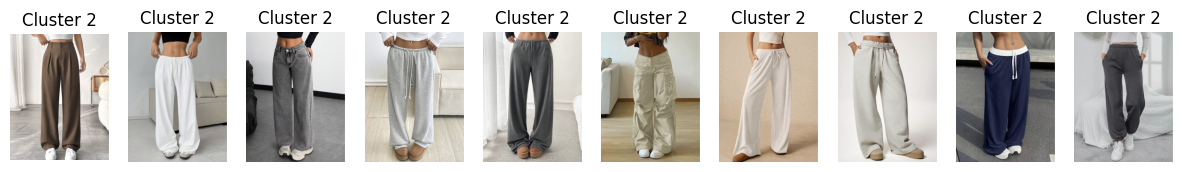

Displaying images for Cluster 0:


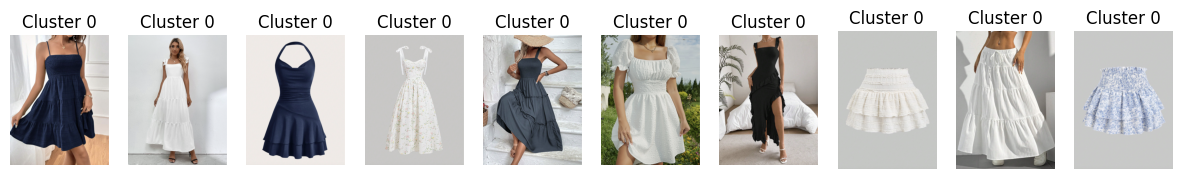

In [20]:
# Show images for each detected cluster
for cluster_id in clusters:
    display_cluster_images(cluster_id)